In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

from numba import jit, cuda

# Theory
## zero mean for noise
For a model with stochastic differential equations (SDE) in the form

$dx(t) = A x(t) dt + B dt + H dW(t)$

its solution has the form

$x(t+\Delta t) = e^{A \Delta t} x(t) + \int_0^{\Delta t} e^{A(\Delta t -u)} B du +\int_0^{\Delta t} e^{A(\Delta t -u)} H dW(u) $

Define $I(\Delta t) = \int_0^{\Delta t} f(\Delta t, u) dW(u)$ where $f(\Delta t, u) = e^{A(\Delta t - u)} H$. The exact series representation is $I(\Delta t) {\buildrel d \over =} \Delta t^{1/\alpha} \sum_i^\infty  \Gamma_i^{-1/\alpha} f(\Delta t, V_i) U_i$ where $V_i$ is iid random variables uniformly distributed in $(0,\Delta t]$ and $\Gamma_i$ is unit rate Poisson process arrival times, i.e. $(\Gamma_{i+1}-\Gamma_i)\tilde{}exp(1)$ and $exp(1)$ is an exponential distribution with mean $1$. And $U_i \tilde{} \mathcal{N}(0, \sigma_w^2)$

If we truncate the infinite jumps, we have

$I_c(\Delta t) = \Delta t^{1/\alpha} \sum_{\Gamma_i<c\Delta t}  \Gamma_i^{-1/\alpha} f(\Delta t, V_i) U_i$

This follows a conditionally normal distribution

$I_c(\Delta t)|\{\Gamma_i, V_i\}^c_{\Delta t} \tilde{} \mathcal{N} (0, \Delta t^{2/\alpha} \sigma_w^2 \sum_{\Gamma_i<c\Delta t} \Gamma_i^{-2/\alpha} f(\Delta t, V_i)f(\Delta t, V_i)^T)$

The residuals can be approximated by a Gaussian

$R_c(\Delta t) = \Delta t^{1/\alpha} \sum_{\Gamma_i \geq c\Delta t}  \Gamma_i^{-1/\alpha} f(\Delta t, V_i) U_i$

$\tilde{R_c}(\Delta t) \tilde{} \mathcal{N} (0, \sigma_w^2 \frac{\alpha}{2-\alpha} c^{1-2/\alpha} Q(\Delta t))$

Combine the terms together, we get

$p(x(t+\Delta t)|x(t),\{\Gamma_i, V_i\}^c_{\Delta t})
= \mathcal{N} (F(\Delta t)x(t), S(\Delta t))$

where $S(\Delta t) = \Delta t^{2/\alpha} \sigma_w^2 \sum_{\Gamma_i<c\Delta t} \Gamma_i^{-2/\alpha} f(\Delta t, V_i)f(\Delta t, V_i)^T + \sigma_w^2 \frac{\alpha}{2-\alpha} c^{1-2/\alpha} Q(\Delta t)$

and $F(\Delta t)x(t)=e^{A \Delta t}$, $M(\Delta t) = \int^{\Delta t}_0 e^{A(\Delta t -u )} B du$.

## non zero mean
if $U_i \tilde{} \mathcal{N}(\mu_w, \sigma_w^2)$, then there is an extra centering term when calculating $I(\Delta t)$.

$I_c(\Delta_t) = \Delta t^{1/\alpha} \sum_{\Gamma_i<c\Delta t}  \Gamma_i^{-1/\alpha} f(\Delta t, V_i) U_i - \mathcal{I}(\alpha>1) \mu_w \frac{\alpha}{\alpha-1} c^{1-1/\alpha} \int^{t+\Delta t}_t f(t+\Delta t, u) du$

Define the frist term and the second term as $Z^c_{\Delta_t}$ and $\hat{Z}^c_{\Delta t}$ respectively. Note that $\int^{t+\Delta t}_t f(t+\Delta t, u) du = \int^{\Delta t}_0 f(\Delta t, u) du$ due to properties of levy process.

Next, we add residual terms, which is again approximated by a Gaussian $\tilde{R_c}(\Delta t) \tilde{} \mathcal{N} (0, (\sigma^2_w + \mu_w^2) \Sigma_{\Delta t}^c$ where

$\Sigma_{\Delta t}^c = (\sigma^2_w + \mu_w^2) \frac{\alpha}{2-\alpha} c^{1-2/\alpha} Q(\Delta t)$

similar as before, except for an extra $\mu_w$ term.

Finally, we combine the terms together and get

$x(t+\Delta t) = e^{A\Delta t} x(t) + Z^c_{\Delta_t} - \hat{Z}^c_{\Delta t} +\tilde{R_c}(\Delta t) $

which follows a Gaussian distribution

$p(x(t+\Delta t)|x(t),\{\Gamma_i, V_i\}^c_{\Delta t})
= \mathcal{N} (F(\Delta t)x(t)+ \mu_w m^c_{\Delta t} - \hat{Z}^c_{\Delta t}, \sigma^2 S^c_{\Delta t} + (\sigma_w^2+\mu_w^2) \Sigma_{\Delta t}^c)$

where

$m^c_{\Delta t} = \Delta t^{1/\alpha} \sum_{\Gamma_i<c\Delta t} \Gamma_i^{-1/\alpha} e^{A(\Delta t - V_i)} h$

$S^c_{\Delta t} = \Delta t^{2/\alpha} \sum_{\Gamma_i<c\Delta t} \Gamma_i^{-2/\alpha} e^{A(\Delta t - V_i)}h h^T {e^{A(\Delta t - V_i)}}^T$

# Object tracking
## Models
### Langevin
First we do simulations for tracking models, starting with Langevin model, where we have
$a_j = \begin{bmatrix} 0 & 1 \\ 0 & -\lambda \end{bmatrix}$ and
$h_j = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

Because there is no $B$ terms, $M(\Delta t) = 0$. To calculate the mean and variance, we start with the result

$\text{exp}(\begin{bmatrix} 0 & 1 \\ 0 & -\lambda \end{bmatrix} t) = 
\begin{bmatrix} 1 & -\frac{1}{\lambda}(e^{-t \lambda}-1) \\
0 & e^{-t \lambda} \end{bmatrix}$

After calculation we get

$q_i = \begin{bmatrix} 0 & \frac{1}{2 \lambda^2}+\frac{1}{2 \lambda^2} e^{-2 \Delta t \lambda}+\frac{1}{\lambda^2}(1-e^{-\Delta t \lambda}) \\
0 & \frac{1}{2 \lambda} (1-e^{-2 \Delta t \lambda}) \end{bmatrix}$

$f_i(\Delta t, V_i) = \begin{bmatrix} -\frac{1}{\lambda} e^{(V_i-\Delta t)\lambda}+\frac{1}{\lambda} \\
e^{(V_i-\Delta t)\lambda} \end{bmatrix}$

tempered stable process, try compensated term with non-zero mean

Lily's work: Data Association and sequential MCMC

parameter estimation: particle MCMC/ sequential MCMC to calculate p(y|$\theta$)

C:\Users\95414\AppData\Local\Temp\ipykernel_104932\3436559418.py:48: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array


Text(0.5, 1.0, 'velocity')

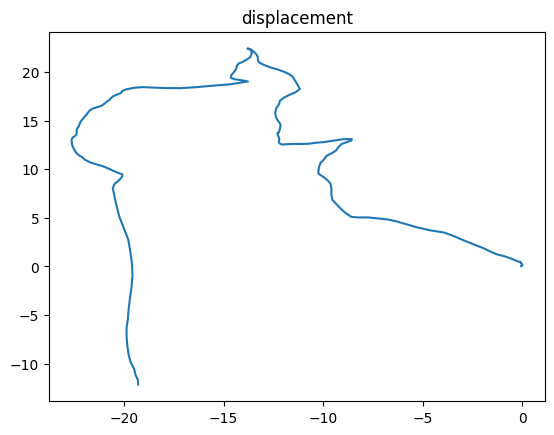

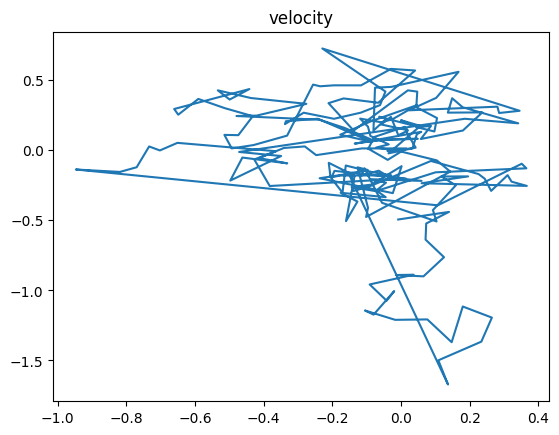

In [26]:
l = 0.1
c = 20
N = 200
delta_t = 1
sigma_w = 0.033
alpha = 1.6

noise_sig = 0.001

def simu_langevin(l, c, N, delta_t, sigma_w, alpha, noise_sig):
    x = np.matrix([0,0,0,0]).T # vertical matrix
    x_ns = np.zeros((N,4))
    t_ns = np.zeros(N)
    y_ns = np.zeros((N,4))
    
    jump_sums = []

    for n in range(N):
        gamma = 0
        sum_n = 0
        while gamma<c*delta_t:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,delta_t)
            while v_i==0:
                v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero

            f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
            f2 = np.exp(-(delta_t-v_i)*l)
            f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])

            sum_i = gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
    #         print(sum_i,sum_i_1)
            sum_n+=sum_i

        q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        q22 = (1-np.exp(-2*delta_t*l))/(2*l)
        Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],[0,0,0,q12],[0,0,0,q22]])
        S_delta_t = delta_t**(2/alpha)*sigma_w**2*sum_n + sigma_w**2*alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
        
        jump_sums.append(S_delta_t)

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)

        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
    
    noise = np.random.normal(0, noise_sig, (N, 4))
    noise[:,1] /= 100
    noise[:,3] /= 100
    y_ns = x_ns+noise
    return t_ns, x_ns, y_ns, jump_sums

t_ns, x_ns, y_ns,_ = simu_langevin(l, c, N, delta_t, sigma_w, alpha, noise_sig)
plt.figure()
plt.plot(x_ns[:,0], x_ns[:,2])  
plt.title('displacement') 
plt.figure()
plt.plot(x_ns[:,1], x_ns[:,3])  
plt.title('velocity') 

Consider non-zero mean, we start with the result

$\text{exp}(\begin{bmatrix} 0 & 1 \\ 0 & -\lambda \end{bmatrix} t) = 
\begin{bmatrix} 1 & -\frac{1}{\lambda}(e^{-t \lambda}-1) \\
0 & e^{-t \lambda} \end{bmatrix}$

After calculation we get

$q_i = \begin{bmatrix} 0 & \frac{1}{2 \lambda^2}+\frac{1}{2 \lambda^2} e^{-2 \Delta t \lambda}+\frac{1}{\lambda^2}(1-e^{-\Delta t \lambda}) \\
0 & \frac{1}{2 \lambda} (1-e^{-2 \Delta t \lambda}) \end{bmatrix}$

$f_i(\Delta t, V_i) = \begin{bmatrix} -\frac{1}{\lambda} e^{(V_i-\Delta t)\lambda}+\frac{1}{\lambda} \\
e^{(V_i-\Delta t)\lambda} \end{bmatrix}$

### Singer
Now consider Singer model, where we have
$a_j = \begin{bmatrix} 0 & 1 & 0 \\ 0 &0 &1 \\ 0 & 0 & -\lambda \end{bmatrix}$ and
$h_j = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$

Because there is no $B$ terms, $M(\Delta t) = 0$. To calculate the mean and variance, we start with the result

$\text{exp}(\begin{bmatrix} 0 & 1 & 0 \\ 0 &0 &1 \\ 0 & 0 & -\lambda \end{bmatrix} t) = 
\begin{bmatrix} 1 & t & \frac{1}{\lambda^2}(e^{-t \lambda}-1+t \lambda) \\
0 & 1 & \frac{1}{\lambda}(1- e^{-t \lambda})
0 & 0 & e^{-t \lambda} \end{bmatrix}$

Noticing that the last 2 rows follows from the matrix exponential for Langevin model, because here $a$ has the same SDE as $v$ in Langevin model. After calculation we get

$q_i = 
\begin{bmatrix} -\frac{1}{\lambda^4}(\frac{1}{2 \lambda} (1-e^{-2 \Delta t \lambda})+\frac{1}{3} \lambda^2 \Delta t^3 -\lambda \Delta t^2 + \Delta t + 2(t-\frac{1}{\lambda}+1)(1-e^{\Delta t \lambda})) & q_i^{21} & q_i^{31} \\
\frac{1}{\lambda^3} (-\frac{1}{2 \lambda} (1- e^{-2\Delta t \lambda})-\Delta t +\frac{1}{2}\lambda \Delta t^2 + 1 + \frac{2}{\lambda} + e^{-\Delta t\lambda}(\Delta t - \frac{2}{\lambda}-1)) & \frac{1}{\lambda^2} (\Delta t + \frac{1}{2 \lambda}(1-e^{-2 \Delta t \lambda})-\frac{2}{\lambda}(1-e^{- \Delta t \lambda})) & q_i^{32}\\
\frac{1}{\lambda^2}(-\frac{1}{2 \lambda}(e^{-2\Delta t \lambda}-1)+\frac{1}{\lambda} e^{-\Delta t \lambda}(1+\lambda -\Delta t \lambda)+\frac{1}{\lambda}-1) & \frac{1}{\lambda^2}(1-e^{-\Delta t \lambda}-\frac{1}{2}(1-e^{-2 \Delta t \lambda})) & \frac{1}{2 \lambda} (1-e^{-2 \Delta t \lambda})
\end{bmatrix}$

$f_i(\Delta t, V_i) = \begin{bmatrix} -\frac{1}{\lambda} e^{(V_i-\Delta t)\lambda}+\frac{1}{\lambda} \\
e^{(V_i-\Delta t)\lambda} \end{bmatrix}$

C:\Users\surface\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: covariance is not positive-semidefinite.


Text(0.5, 1.0, 'acceleration')

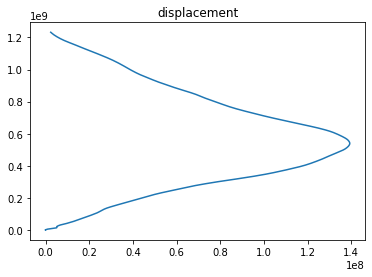

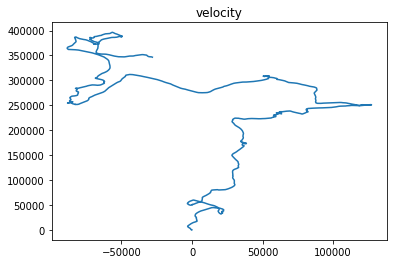

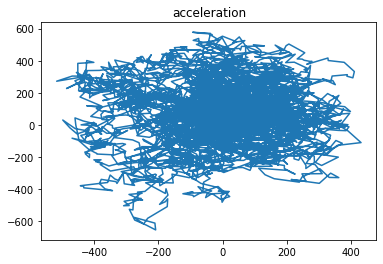

In [3]:
l = 0.0145
c = 20
N = 5000
delta_t = 1
sigma_w = 0.033
alpha = 1.6

x = np.matrix([0,0,0,0,0,0]).T # vertical matrix
x_ns = np.zeros((N,6))
t_ns = np.zeros(N)

for n in range(N):
    gamma = 0
    sum_n = 0
    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        f1 = (np.exp(l*(v_i-delta_t))-1+(delta_t-v_i)*l)/l**2
        f2 = (1-np.exp((v_i-delta_t)*l))/l
        f3 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[f3,0],[0,f1],[0,f2],[0,f3]])
        
        sum_i = gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
#         print(sum_i,sum_i_1)
        sum_n+=sum_i
    
    q11 = -((1-np.exp(-2*delta_t*l))/2/l + l**2*delta_t**3/3 - l*delta_t**2 + delta_t + 2*(delta_t-1/l+1)*(1-np.exp(-delta_t*l)))/l**4
    q22 = (delta_t+(1-np.exp(-2*delta_t*l))/2/l-2*(1-np.exp(-delta_t*l))/l)/l**2
    q33 = (1-np.exp(-2*delta_t*l))/2/l
    q12 = (-(1-np.exp(-2*delta_t*l))/2/l-delta_t+l*delta_t**2/2+1+2/l+np.exp(-delta_t*l)*(delta_t-2/l-1))/l**3
    q23 = (1-np.exp(-delta_t*l)-(1-np.exp(-2*delta_t*l))/2)/l**2
    q13 = (-(np.exp(-2*delta_t*l)-1)/2/l + np.exp(-delta_t*l)*(1+l-delta_t*l)/l+1/l-1)/l**2
    
    Q_delta_t = np.matrix([[q11,q12,q13,0,0,0],[q12,q22,q23,0,0,0],[q13,q23,q33,0,0,0],\
                           [0,0,0,q11,q12,q13],[0,0,0,q12,q22,q23],[0,0,0,q13,q23,q33]])
    S_delta_t = delta_t**(2/alpha)*sigma_w**2*sum_n + sigma_w**2*alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
    
    m13 = (np.exp(-delta_t*l)-1+delta_t*l)/l**2
    m23 = (1-np.exp(-delta_t*l))/l
    m33 = np.exp(-delta_t*l)
    
    m_delta_t = np.matmul(np.matrix([[1,delta_t,m13,0,0,0],[0,1,m23,0,0,0],[0,0,m33,0,0,0],\
                                     [0,0,0,1,delta_t,m13],[0,0,0,0,1,m23],[0,0,0,0,0,m33],]),x)

    x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

    x_ns[n,:]=x
    x = np.matrix(x).T # transform x to be a vertical matrix
    t_ns[n]=n*delta_t

plt.figure()
plt.plot(x_ns[:,0], x_ns[:,3])
plt.title('displacement')

plt.figure()
plt.plot(x_ns[:,1], x_ns[:,4])
plt.title('velocity')

plt.figure()
plt.plot(x_ns[:,2], x_ns[:,5])
plt.title('acceleration')

## Tracking by particle filtering
Consider Langevin model, first simulate noisy data.

In [4]:
l = 0.001
c = 20
N = 100
delta_t = 1
sigma_w = 0.033
alpha = 1.6

noise_sig = 4
t_ns, x_ns, y_ns, jump_sums = simu_langevin(l, c, N, delta_t, sigma_w, alpha, noise_sig)
plt.figure()
plt.plot(y_ns[:,0], y_ns[:,2]) 
plt.plot(x_ns[:,0], x_ns[:,2])  
plt.legend(['noisy','orig'])
plt.title('displacement') 
plt.figure()
plt.plot(y_ns[:,1], y_ns[:,3]) 
plt.plot(x_ns[:,1], x_ns[:,3]) 
plt.title('velocity')

NameError: name 'simu_langevin' is not defined

In [37]:
# tracking zero-mean langevin, alpha stable
def sampling_latent_variables_zeromean(delta_t, sigma_w, alpha):
    gammas = []
    vs = []
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0
    
    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T) 
    
    return s_c_dt

def single_ite_particle_filtering_zeromean(jump_sum, y_n, log_weight_p, mu_p, P_p, delta_t, sigma_w, alpha,l, noise_sig, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]

        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    R = np.identity(4)*noise_sig**2
    R[1,1] /= 20
    R[3,3] /= 20
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    
    q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
    q22 = (1-np.exp(-2*delta_t*l))/(2*l)
    Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],[0,0,0,q12],[0,0,0,q22]])
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    A = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    for p in range(num_particles):
        s_c_dt = sampling_latent_variables_zeromean(delta_t, sigma_w, alpha)
#         s_c_dt = delta_t**(2/alpha)*jump_sum
        S = s_c_dt*sigma_w**2 + sigma_w**2*alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
#         S = jump_sum
        
        mu_n_prev_n = np.matmul(A,mu_p[p])
        P_n_prev_n = A*P_p[p]*A.T + S

        y_hat_n_prev_n = mu_n_prev_n
        sigma_n_prev_n = P_n_prev_n + R
        K = P_n_prev_n*np.linalg.inv(sigma_n_prev_n)
#         mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(4) - K)*P_n_prev_n
        mu_n_n = P_n_n*(np.linalg.inv(P_n_prev_n)*mu_n_prev_n + np.linalg.inv(R)*y_n)
        
        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)
    
#         update weights
        log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
#         log_w_p_nextn = np.log(np.ones(num_particles)*(1/num_particles))
        log_weights_p_nextn[p] = log_w_p_nextn
#         if np.isinf(log_w_p_nextn):
#             import pdb;pdb.set_trace()
    
    # normalise weights
    log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, S, K

In [4]:
l = 0.01
c = 20
N = 100
delta_t = 1
sigma_w = 0.033
alpha = 1.6 #1.9

noise_sig = 3

n_mus = []
n_Ps = []
n_ws = []
s =[]
k = []
num_particles = 20

# initialize x
mu_p = [np.matrix(np.zeros(4)).T]*num_particles
P_p = [np.matrix(np.identity(4))*10]*num_particles
log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
for n in range(N):
    
#     jump_sum = jump_sums[n]
    jump_sum = 0
    y_n = np.matrix(y_ns[n]).T
    weight_p, mu_p, P_p, S_delta_t, K = single_ite_particle_filtering_zeromean(jump_sum, np.matrix(y_ns[n]).T, log_weight_p, mu_p, P_p, delta_t, sigma_w, alpha,l, noise_sig, resample = True)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(weight_p)
    s.append(S_delta_t)
    k.append(K)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_ws = np.array(n_ws)
s = np.array(s)
k = np.array(k)

NameError: name 'y_ns' is not defined

In [10]:
print(n_mus.shape, n_ws.shape)
n_Ps.shape

(100, 10, 4, 1) (100, 10)


(100, 10, 4, 4)

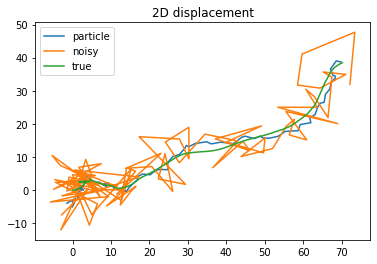

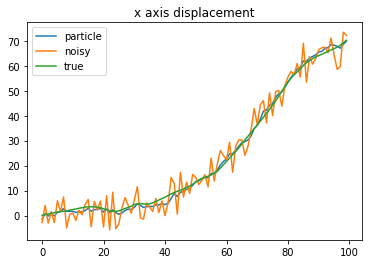

In [43]:
plt.figure()
plt.title('2D displacement')
plt.plot(n_mus[:,0,0,0],n_mus[:,0,2,0])
# plt.plot(n_mus[:,0,0], n_mus[:,0,2])
plt.plot(y_ns[:,0],y_ns[:,2])
plt.plot(x_ns[:,0],x_ns[:,2])
plt.legend(['particle','noisy','true'])
plt.savefig('Langevin_alpha_stable.png')

plt.figure()
plt.title('x axis displacement')
plt.plot(n_mus[:,0,0,0])
plt.plot(y_ns[:,0])
plt.plot(x_ns[:,0])
plt.legend(['particle','noisy','true'])

1.3466714021937685 20.393463338505533


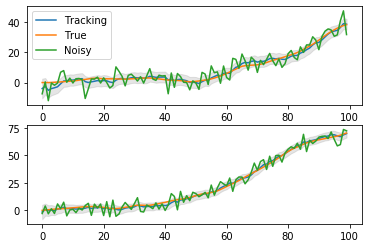

In [47]:
average = np.zeros((N, 4))
std3 = np.zeros((N, 4))
avg_P = np.zeros((N, 4, 4))

for i in range(N):
    for d in range(4):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], np.exp(n_ws[i,:]))
        for j in range(4):
            avg_P[i,d,j] = np.dot(np.array(n_Ps[i,:,d,j].T), np.exp(n_ws[i,:]))+\
            np.dot((np.array(n_mus[i,:,d,:].T)[0]-average[i,d])*(np.array(n_mus[i,:,j,:].T)[0]-average[i,j]), np.exp(n_ws[i,:]))
            
        std3[i,d]=np.sqrt(avg_P[i,d,d])*3

# plot error region
plt.figure()
plt.subplot(2,1,1)
plt.fill_between(range(N), average[:,2] - std3[:,2], average[:,2] + std3[:,2],
                 color='gray', alpha=0.2)
plt.plot(average[:,2])
plt.plot(x_ns[:,2])
plt.plot(y_ns[:,2])
plt.legend(['Tracking', 'True','Noisy'])
plt.subplot(2,1,2)
plt.fill_between(range(N), average[:,0] - std3[:,0], average[:,0] + std3[:,0],
                 color='gray', alpha=0.2)
plt.plot(average[:,0])
plt.plot(x_ns[:,0])
plt.plot(y_ns[:,0])
plt.savefig('Langevin_alpha_stable.png')
error = np.dot(average[:,0]-x_ns[:,0],average[:,0]-x_ns[:,0])/N
error_orig = np.dot(y_ns[:,0]-x_ns[:,0],y_ns[:,0]-x_ns[:,0])/N
print(error, error_orig)

## Langevin with non zero mean

Text(0.5, 1.0, 'velocity')

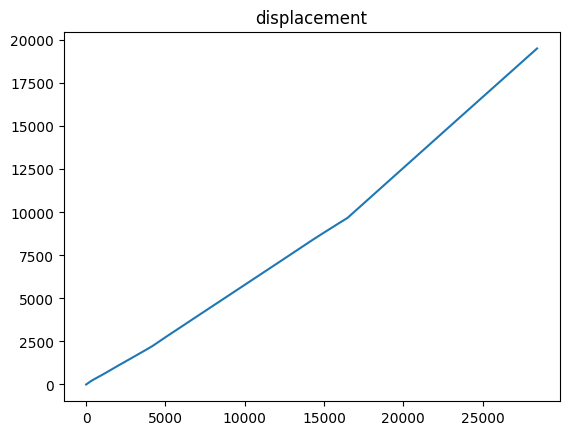

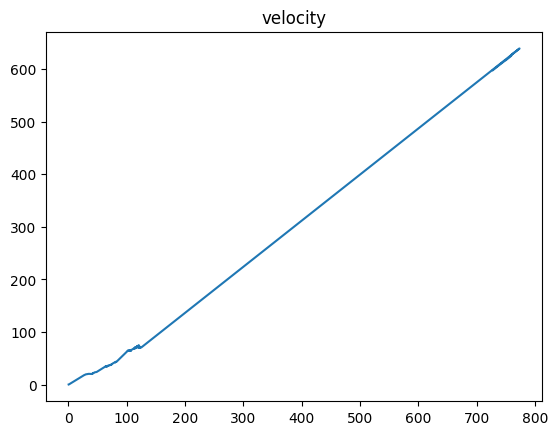

In [209]:
# constant mu generate trajectory
l = 0.005
c = 10 # 10
N = 200
delta_t = 1
sigma_w = 0.033
mu_w1 = 0.1
mu_w2 = 0.05
alpha = 0.9

def simu_langevin_non_zero():
    x = np.matrix([0,0,0,0]).T # vertical matrix
    x_ns = np.zeros((N,4))
    t_ns = np.zeros(N)
    
    s_ns = np.zeros((N,4,4))
    m_ns_dt = np.zeros((N,4))
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    Q_delta_t1 *= sigma_w**2
    
    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1
    Q_delta_t[2:,2:] = Q_delta_t1

    for n in range(N):
        gamma = 0

        m_c_dt = 0
        s_c_dt = 0
        while gamma<c*delta_t:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,delta_t)
            while v_i==0:
                v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero

            # calculate mean delta t^c      
            f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
            f2 = np.exp(-(delta_t-v_i)*l)
            f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
            f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
            m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
            s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)


        # q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        # q22 = (1-np.exp(-2*delta_t*l))/(2*l)
#         Q_delta_t = np.matrix([[0,q12*(sigma_w**2+mu_w1**2),0,0],[0,q22*(sigma_w**2+mu_w1**2),0,0],
#                                [0,0,0,q12*(sigma_w**2+mu_w2**2)],[0,0,0,q22*(sigma_w**2+mu_w2**2)]])
        # Q_delta_t = np.matrix([[0,q12*sigma_w**2,0,0],[0,q22*(sigma_w**2),0,0],
        #                        [0,0,0,q12*(sigma_w**2)],[0,0,0,q22*(sigma_w**2)]])
        S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
        
        s_ns[n,:,:]=S_delta_t
        m_ns_dt[n,:]=np.array(m_c_dt.T)[0]

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        # centering term
        c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
        c2 = (1-np.exp(-l*delta_t))/l
        Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T

        m_c_dt[0:2] *= mu_w1
        m_c_dt[2:] *= mu_w2
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)+m_c_dt


        if alpha > 1:
            m_delta_t -= Z_c_bar

        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
        
    return x_ns, t_ns,s_ns, m_ns_dt 

x_ns, t_ns,s_ns, m_ns_dt = simu_langevin_non_zero()
plt.figure()
plt.plot(x_ns[:,0], x_ns[:,2])  
# plt.plot(x_ns_test[:,0], x_ns_test[:,2])  
plt.title('displacement') 
# plt.legend(['test','true'])

plt.figure()
plt.plot(x_ns[:,1], x_ns[:,3])  
# plt.plot(x_ns_test[:,1], x_ns_test[:,3])  
plt.title('velocity') 
# plt.legend(['test','true'])


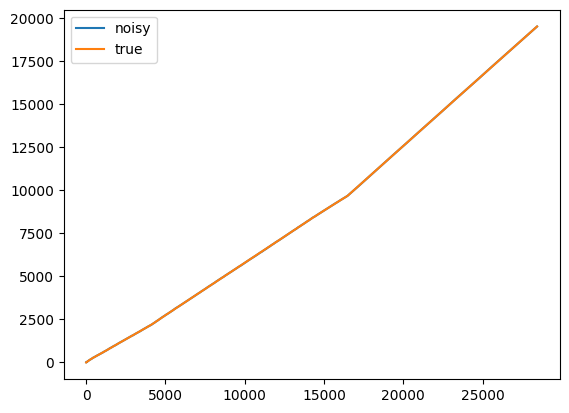

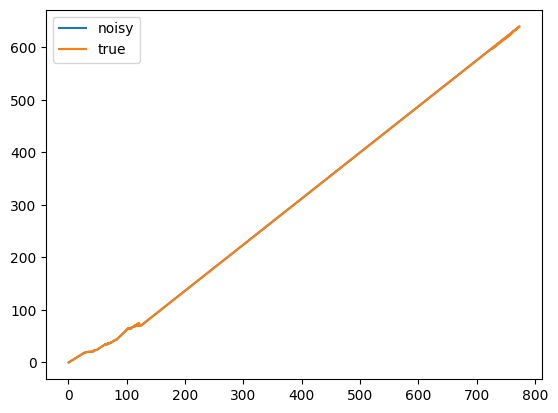

In [210]:
# add noise const mu
k_v = 100
noise_sig = sigma_w*k_v
noise = np.random.normal(0, noise_sig, (N, 4))
noise[:,1] /= 20
noise[:,3] /= 20
y_ns = x_ns+noise # noisy data

plt.figure()
plt.plot(y_ns[:,0], y_ns[:,2])
plt.plot(x_ns[:,0],x_ns[:,2])
plt.legend(['noisy', 'true'])
plt.figure()
plt.plot(y_ns[:,1], y_ns[:,3])
plt.plot(x_ns[:,1],x_ns[:,3])
plt.legend(['noisy', 'true'])
y_ns = y_ns[:,(0,2)]

In [171]:
# prepare algorithm for later use
def sampling_latent_variables(delta_t, sigma_w, alpha):
    gammas = []
    vs = []
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    Q_delta_t1 *= sigma_w**2
    
    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1
    Q_delta_t[2:,2:] = Q_delta_t1

    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
        m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        
    
#     q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
#     q22 = (1-np.exp(-2*delta_t*l))/(2*l)
    v = sigma_w**2 # or sigma^2 + mu^2
#     Q_delta_t = np.matrix([[0,q12*sigma_w**2,0,0],[0,q22*sigma_w**2,0,0],
#                            [0,0,0,q12*sigma_w**2],[0,0,0,q22*sigma_w**2]])
    S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
    Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T
    if alpha<1:
        Z_c_bar = 0
    
    m_c_dt[0:2] *= mu_w1
    m_c_dt[2:] *= mu_w2
    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    m_c_y_c=m_c_dt - Z_c_bar
    
    return m_c_y_c, S_delta_t, e_Adt

def single_ite_particle_filtering(y_n, weight_p, mu_p, P_p, delta_t, sigma_w, alpha,l, noise_sig, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = weight_p)
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        weight_p = np.ones(num_particles)*(1/num_particles)
    
    R = np.identity(4)*noise_sig**2
    R[:,1] /= 20
    R[:,3] /= 20
    
    
    mu_p_nextn = []
    P_p_nextn = []
    weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
#         print(p)
        m, S, eA = sampling_latent_variables(delta_t, sigma_w, alpha)

        mu_n_prev_n = eA*mu_p[p] + m
        P_n_prev_n = eA*P_p[p]*eA.T + S
        y_hat_n_prev_n = mu_n_prev_n
        sigma_n_prev_n = P_n_prev_n + R
        K = P_n_prev_n*np.linalg.inv(sigma_n_prev_n)
#         mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(4) - K)*P_n_prev_n
        mu_n_n = P_n_n*(np.linalg.inv(P_n_prev_n)*mu_n_prev_n + np.linalg.inv(R)*y_n)
        
        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        
    
        # normalise weights
        w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0])
        weights_p_nextn[p] = w_p_nextn
    
    # normalise weights
    if sum(weights_p_nextn)==0:
        weights_p_nextn = np.ones(num_particles)*(1/num_particles)
    else:
        weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return weights_p_nextn, mu_p_nextn, P_p_nextn

In [10]:
n_mus = []
n_Ps = []
n_ws = []
num_particles = 10

# initialize x
mu_p = [np.matrix(np.zeros(4)).T]*num_particles
P_p = [np.matrix(np.identity(4))*10]*num_particles
weight_p = np.ones(num_particles)*(1/num_particles)
E_ns = np.zeros((num_particles, N+1)) # store exp likelihood of y
for n in range(N):

    y_n = np.matrix(y_ns[n]).T
    weight_p, mu_p, P_p ,E_ns= single_ite_particle_filtering(y_n, weight_p, mu_p, P_p,E_ns, delta_t, sigma_w, alpha,l, noise_sig, resample = True)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_ws = np.array(n_ws)

ValueError: shapes (4,4) and (2,1) not aligned: 4 (dim 1) != 2 (dim 0)

(200, 10, 4, 1) (200, 10)
[-0.93470962 -0.99894301 -0.84133888 -0.89417201 -0.97947477 -1.01865285
 -0.99158369 -0.86912787 -0.90707492 -1.01502874] [0.00530902 0.10725612 0.0869934  0.12946167 0.09828914 0.11976747
 0.1096901  0.10954911 0.13007483 0.10360915]
0.696539406638388


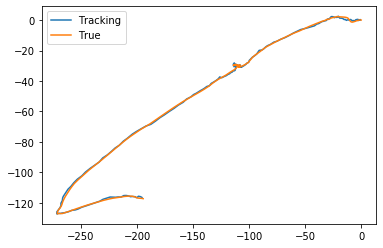

In [396]:
print(n_mus.shape, n_ws.shape)
average = np.zeros((N, 4))
print(np.array(n_mus[0,:,0,:].T)[0], n_ws[-1,:].T)

for i in range(N):
    for d in range(4):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], n_ws[i,:])

plt.plot(average[:,0], average[:,2])
plt.plot(x_ns[:,0], x_ns[:,2])
plt.legend(['Tracking', 'True'])
error = np.dot(average[:,0]-x_ns[:,0],average[:,0]-x_ns[:,0])/N
print(error)

In [13]:
# prepare algorithm for later use
alpha_w = 0.000000000001
beta_w = 0.000000000001
k_mu1 = 0.0
k_mu2 = 0.0
def returnQ(delta_t):
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3

    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1 * (1+delta_t*k_mu1**2)
    Q_delta_t[2:,2:] = Q_delta_t1 * (1+delta_t*k_mu2**2)

    return Q_delta_t
def prediction_step(v_i, gamma, T, delta_t):
    # calculate mean delta t^c      
    f1 = -np.exp(-l*(v_i-v_i))/l+1/l
    f2 = np.exp(-(v_i-v_i)*l)
    f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
    f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
    if gamma == 0:
        m_c_y_c = np.matrix([0.0,0.0,0.0,0.0]).T
        s_c_dt = 0.0 * np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
    else:
        m_c_y_c = T**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt = T**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)

    Q_delta_t = returnQ(delta_t)
    Q_delta_t[:2,:2]*= (delta_t*k_mu1**2+1)
    Q_delta_t[2:,2:]*= (delta_t*k_mu2**2+1)
    C_e = s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e

    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])

    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
#     Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2,c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0.0* np.matrix([c1,c2,c1,c2]).T
    m_c_y_c-=Z_c_bar_divMu

    # construct A
    A = np.matrix(np.zeros((6,6)))
    A[:4,:4] = e_Adt
    A[0,4] = m_c_y_c[0]
    A[1,4] = m_c_y_c[1]
    A[2,5] = m_c_y_c[2]
    A[3,5] = m_c_y_c[3]
    A[4:,4:] = np.identity(2)
    B = np.matrix(np.zeros((6,4)))
    B[:4,:4] = np.identity(4)

    return A, B, C_e

def sampling_latent_variables_para_j(T, alpha, mu_p, P_p):
    gammas = []
    vs = []
    
    gamma = 0
    while gamma<c*T:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,T)
        while v_i==0:
            v_i = np.random.uniform(0,T) # need to make sure v_i is non-zero

        gammas.append(gamma)
        vs.append(v_i)

    # order jumps
    gammas = [x for _,x in sorted(zip(vs, gammas))]
    vs.sort()

    v0 = 0.0
    for v_i, gamma in zip(vs, gammas):
        # prediction step repeatedly
        delta_t = v_i - v0
        v0 = v_i

        A, B, C_e = prediction_step(v_i, gamma, T, delta_t)

        mu_p = A*mu_p
        P_p = A*P_p*A.T + B* C_e*B.T

    # final step, zero jump
    delta_t = T -v0
    A, B, C_e = prediction_step(v_i, 0.0, T, delta_t)
    mu_p = A*mu_p
    P_p = A*P_p*A.T + B* C_e*B.T
    
    return mu_p, P_p

In [195]:
# 2d tracking const mu
alpha_w = 0.000000000001
beta_w = 0.000000000001

def sampling_latent_variables_para(delta_t, sigma_w, alpha, s_n, m_n):
    gammas = []
    vs = []
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t1 = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    
    Q_delta_t = np.matrix(np.zeros((4,4)))
    Q_delta_t[:2,:2] = Q_delta_t1
    Q_delta_t[2:,2:] = Q_delta_t1

    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
        m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        

    S_delta_t = s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e


    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2,c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0

    e_Adt = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    m_c_y_c=m_c_dt - Z_c_bar_divMu
    
    # construct A
    A = np.matrix(np.zeros((6,6)))
    A[:4,:4] = e_Adt
    A[0,4] = m_c_y_c[0]
    A[1,4] = m_c_y_c[1]
    A[2,5] = m_c_y_c[2]
    A[3,5] = m_c_y_c[3]
    A[4:,4:] = np.identity(2)
    B = np.matrix(np.zeros((6,4)))
    B[:4,:4] = np.identity(4)
    
    return A, B, S_delta_t

def single_ite_particle_filtering_para(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((2,6)))
    C[0,0] = 1
    C[1,2] = 1 # observation matrix
    R = np.matrix(np.zeros)
    R = np.identity(2)*k_v**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
        A, B, C_e = sampling_latent_variables_para(delta_t, sigma_w, alpha, s_n, m_n)

        mu_n_prev_n = A*mu_p[p]
        P_n_prev_n = A*P_p[p]*A.T + B* C_e*B.T
        # mu_n_prev_n, P_n_prev_n = sampling_latent_variables_para_j(1, alpha, mu_p[p], P_p[p])

        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(6) - K*C)*P_n_prev_n

        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        # count sigma_w in
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:])
#         import pdb;pdb.set_trace()
        log_like = -0.5*np.log(np.linalg.det(sigma_n_prev_n))-(alpha_w+n/2)*np.log(beta_w_post_p)\
                    +(alpha_w+n/2-1/2)*np.log(beta_w - sum(E_ns[p,:n]))+\
                    scipy.special.loggamma(n/2+alpha_w)-scipy.special.loggamma(n/2+alpha_w-1/2) # -2/2*np.log(2*np.pi)
    
        # normalise weights
        # log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)
        log_w_p_nextn = log_weight_p[p]+log_like
#         log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    except:
        import pdb;pdb.set_trace()
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

In [196]:
# particle filter

n_mus = []
n_Ps = []
n_ws = []
num_particles = 50

# initialize x
mu_p_1 = np.matrix(np.zeros(6)).T
# mu_p_1[4:,0] = np.matrix([[mu_w1],[mu_w1]])
mu_p = [mu_p_1]*num_particles
P_i = np.matrix(np.identity(6))*0.01
P_i[4,4] = 100
P_i[5,5] = 100
P_p = [P_i]*num_particles
log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))

E_ns = np.zeros((num_particles, N+1)) # store exp likelihood of y

for n in range(N):
#     y_n = np.matrix(np.zeros(8)).T
#     y_n[:4]=np.matrix(y_ns[n]).T
    y_n = np.matrix(y_ns[n]).T
    m_n = np.matrix(m_ns_dt[n,:]).T
    s_n = np.matrix(s_ns[n,:,:])
    if n%5 == 0:
        resample = True
    else:
        resample = False
    # resample = True
    log_weight_p, mu_p, P_p, E_ns = single_ite_particle_filtering_para(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n+1, resample = resample)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(log_weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_Ps *= sigma_w**2 # if marginalizing sigma
n_ws = np.array(n_ws)

C:\Users\95414\AppData\Local\Temp\ipykernel_16428\1137232034.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[0,4] = m_c_y_c[0]
C:\Users\95414\AppData\Local\Temp\ipykernel_16428\1137232034.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[1,4] = m_c_y_c[1]
C:\Users\95414\AppData\Local\Temp\ipykernel_16428\1137232034.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[2,5] = m_c_y_c[2]
C:\Users\95414\AppData\Local\Temp\ipykernel_16428\1137232034.py:63:

0.15812655098815648 0.0850298483727368


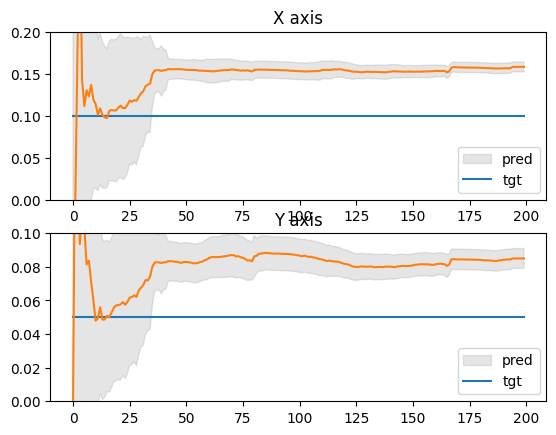

In [197]:
average = np.zeros((N, 6))
std3 = np.zeros((N, 6))
avg_P = np.zeros((N, 6, 6))

for i in range(N):
    for d in range(6):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], np.exp(n_ws[i,:]))
        for j in range(6):
            avg_P[i,d,j] = np.dot(np.array(n_Ps[i,:,d,j].T), np.exp(n_ws[i,:]))+\
            np.dot((np.array(n_mus[i,:,d,:].T)[0]-average[i,d])*(np.array(n_mus[i,:,j,:].T)[0]-average[i,j]), np.exp(n_ws[i,:]))
            
        std3[i,d]=np.sqrt(avg_P[i,d,d])*3

# plot error region
dim = 4
plt.figure()
plt.subplot(2,1,1)
plt.fill_between(range(N),average[:,dim] - std3[:,dim], average[:,dim] + std3[:,dim],
                 color='gray', alpha=0.2)
plt.ylim([-0.0,0.2])
tgt = np.ones(N)*mu_w1
plt.plot(tgt)
plt.plot(average[:,dim])
plt.legend(['pred','tgt'])
plt.title('X axis')

dim = 5
plt.subplot(2,1,2)
plt.fill_between(range(N),average[:,dim] - std3[:,dim], average[:,dim] + std3[:,dim],
                 color='gray', alpha=0.2)
plt.ylim([-0.0,0.1])
tgt = np.ones(N)*mu_w2
plt.plot(tgt)
plt.plot(average[:,dim])
plt.legend(['pred','tgt'])
plt.title('Y axis')
# plt.savefig('predictmu/final_mus.png')

# plt.legend(['mu 1','mu 2'])
# plt.savefig('Langevin_nonzero_mus_fixjump.png')
print(average[-1,4],average[-1,5])

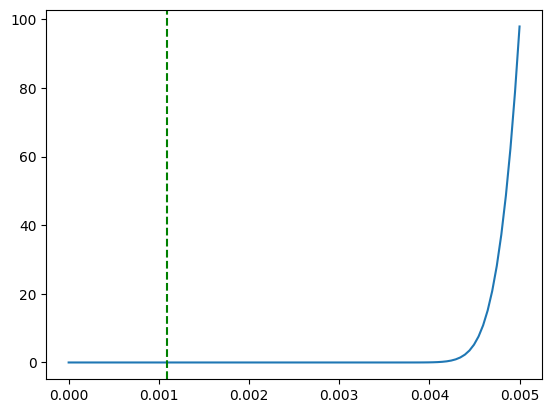

In [198]:
from scipy.stats import invgamma
# plot posterior of sigma
# step 1: get beta from E
betas = np.zeros(N)
alpha = alpha_w + N/2
xs = np.linspace(0.0,0.005,100)
fxs = 0
for p in range(num_particles):
    betas[p] = beta_w - sum(E_ns[p,:])
    x_beta = xs/betas[p]
    pdf = invgamma.pdf(x_beta, alpha)/betas[p]*np.exp(n_ws[-1,p])
    fxs += pdf

plt.plot(xs, fxs)
plt.axvline(x = sigma_w**2, color = 'g', label = 'true sigma',linestyle='dashed',)

(0.0, 0.01)

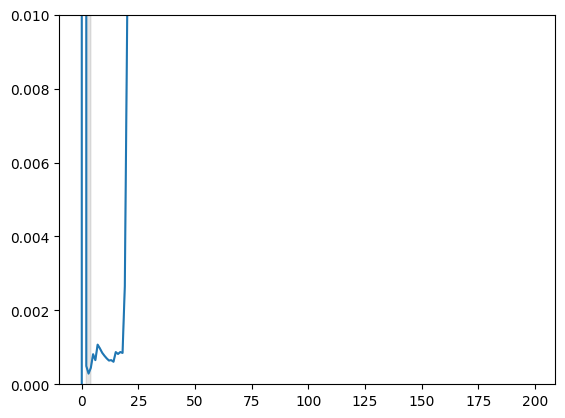

In [271]:
mean_sigmas = np.zeros((N,num_particles))
var_sigmas = np.zeros((N,num_particles))
betas = np.zeros((N, num_particles))
for n in range(N):
    alpha_n = alpha_w + (n+1)/2
    for p in range(num_particles):
        betas[n,p] = beta_w - sum(E_ns[p,:(n+2)])
        mean_sigmas[n,p] = betas[n,p]/(alpha_n-1)
        var_sigmas[n,p] = max(0, betas[n,p]**2/(alpha_n-1)**2/(alpha_n-2))

dim=0
plt.plot(mean_sigmas[:,dim])
plt.fill_between(range(N),mean_sigmas[:,dim] - 3*var_sigmas[:,dim], mean_sigmas[:,dim] + 3*var_sigmas[:,dim],
                 color='gray', alpha=0.2)
plt.ylim([0.0,0.01])

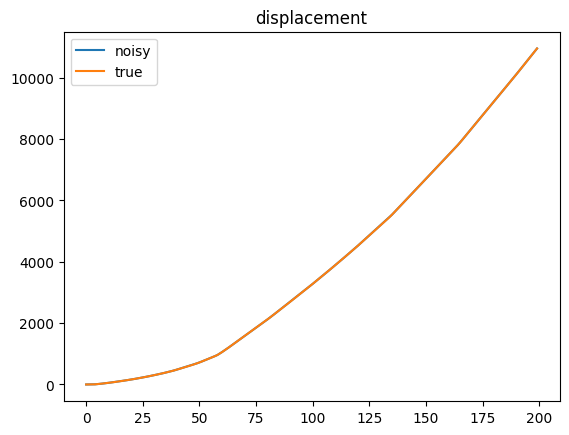

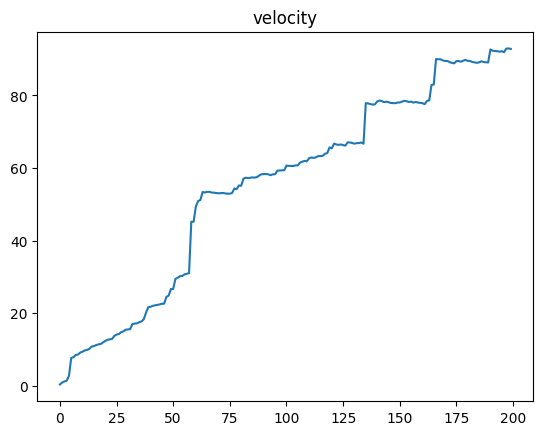

In [280]:
# 1d trajectory, add noise
alpha = 0.9
mu_w1 = 0.1
def simu_langevin_non_zero_1d():
    x = np.matrix([0,0]).T # vertical matrix
    x_ns = np.zeros((N,2))
    t_ns = np.zeros(N)

    s_ns = np.zeros((N,2,2))
    m_ns_dt = np.zeros((N,2))
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    Q_delta_t *= sigma_w**2

    for n in range(N):
        gamma = 0

        m_c_dt = 0
        s_c_dt = 0
        while gamma<c*delta_t:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,delta_t)
            while v_i==0:
                v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero

            # calculate mean delta t^c      
            f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
            f2 = np.exp(-(delta_t-v_i)*l)
            f_delta_t_v_i= np.matrix([f1,f2]).T
            m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i
            s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)


        # q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        # q22 = (1-np.exp(-2*delta_t*l))/(2*l)
#         Q_delta_t = np.matrix([[0,q12*(sigma_w**2+mu_w1**2),0,0],[0,q22*(sigma_w**2+mu_w1**2),0,0],
#                                [0,0,0,q12*(sigma_w**2+mu_w2**2)],[0,0,0,q22*(sigma_w**2+mu_w2**2)]])
        # Q_delta_t = np.matrix([[0,q12*sigma_w**2,0,0],[0,q22*(sigma_w**2),0,0],
        #                        [0,0,0,q12*(sigma_w**2)],[0,0,0,q22*(sigma_w**2)]])
        S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
        
        s_ns[n,:,:]=S_delta_t
        m_ns_dt[n,:]=np.array(m_c_dt.T)[0]

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        # centering term
        c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
        c2 = (1-np.exp(-l*delta_t))/l
        Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2]).T

        if alpha > 1:
            m_c_dt -= Z_c_bar
        m_c_dt*= mu_w1
        m_delta_t = np.matmul(np.matrix([[1,m12],[0,m22]]),x)+m_c_dt
        
        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
        
    return x_ns, t_ns,s_ns, m_ns_dt 

x_ns, t_ns,s_ns, m_ns_dt = simu_langevin_non_zero_1d()
k_v = 10
noise_sig = sigma_w*10
noise = np.random.normal(0, noise_sig, (N, 2))
noise[:,1] /= 20
y_ns = x_ns+noise # noisy data

plt.figure()
plt.plot(y_ns[:,0])
plt.plot(x_ns[:,0])
plt.legend(['noisy', 'true'])
plt.title('displacement') 
# plt.legend(['test','true'])

plt.figure()
plt.plot(x_ns[:,1])  
# plt.plot(x_ns_test[:,1], x_ns_test[:,3])  
plt.title('velocity') 
# plt.legend(['test','true'])
y_ns = y_ns[:,0]


In [281]:
# prepare algorithm for later use, 1d
alpha_w = 0.000000000001
beta_w = 0.000000000001

def sampling_latent_variables_para1d(delta_t, sigma_w, alpha, s_n, m_n):
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0
    
    theta = -l
    M1 = np.matrix([[1/theta**2, 1/theta],[1/theta, 1]])
    M2 = np.matrix([[-2/theta**2, -1/theta],[-1/theta, 0]])
    M3 = np.matrix([[1/theta**2,0],[0,0]])
    Q_delta_t = (np.exp(2*theta*delta_t)-1)/2/theta*M1+ (np.exp(theta*delta_t)-1)/theta*M2 + delta_t*M3
    Q_delta_t *= sigma_w**2
    

    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma
        
        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
        
        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i = np.matrix([f1,f2]).T
        m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
        
    S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t # C_e
    # S_delta_t /= sigma_w**2
    
    # S_delta_t = s_n/sigma_w**2
    # m_c_dt = m_n
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
#     Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T
    if alpha>1:
        Z_c_bar_divMu = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([c1,c2]).T # Y_c
    else:
        Z_c_bar_divMu = 0
    
#     m_c_dt[0:2] *= mu_w1
#     m_c_dt[2:] *= mu_w2
    e_Adt = np.matrix([[1,m12],[0,m22]])
#     import pdb;pdb.set_trace()
    m_c_y_c=m_c_dt - Z_c_bar_divMu
    
    # construct A
    A = np.matrix(np.zeros((3,3)))
    A[:2,:2] = e_Adt
    A[:2,2] = m_c_y_c
    A[2,2] = 1
    B = np.matrix(np.zeros((3,2)))
    B[:2,:2] = np.identity(2)
    
    return A, B, S_delta_t

def single_ite_particle_filtering_para1d(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        # print(np.exp(log_weight_p))
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        # print(indices)
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        E_ns = [E_ns[i,:] for i in indices]
        E_ns = np.array(E_ns)
        
#         weight_p = np.ones(num_particles)*(1/num_particles)
        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    C = np.matrix(np.zeros((1,3)))
    C[0,0] = 1 # observation matrix
    R = np.identity(1)*noise_sig**2 # /sigma_w**2
    
    mu_p_nextn = []
    P_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    for p in range(num_particles):
#         print(p)
        A, B, C_e = sampling_latent_variables_para1d(delta_t, sigma_w, alpha, s_n, m_n)

        mu_n_prev_n = A*mu_p[p]
        P_n_prev_n = A*P_p[p]*A.T + B* C_e*B.T
        y_hat_n_prev_n = C*mu_n_prev_n
        sigma_n_prev_n = C*P_n_prev_n*C.T + R
        K = P_n_prev_n*C.T*np.linalg.inv(sigma_n_prev_n)
        mu_n_n = mu_n_prev_n+K*(y_n-y_hat_n_prev_n)
        P_n_n = (np.identity(3) - K*C)*P_n_prev_n
#         import pdb;pdb.set_trace()
#         mu_n_n = P_n_n*(np.linalg.inv(P_n_prev_n)*mu_n_prev_n + C.T*np.linalg.inv(R)*y_n)
    
        
        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)

#         w_p_nextn = weight_p[p]*stats.multivariate_normal(np.array(mu_n_n.T)[0], P_n_n).pdf(np.array(y_n.T)[0])
#         weights_p_nextn[p] = w_p_nextn
        # count sigma_w in
        sigma_y_norm = sigma_n_prev_n #/ sigma_w**2
        E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_y_norm)*(y_n-y_hat_n_prev_n)/2
        beta_w_post_p = beta_w - sum(E_ns[p,:])
        # import pdb;pdb.set_trace()
        # log_like = -2/2*np.log(2*np.pi)-0.5*np.log(np.linalg.det(sigma_y_norm))-(alpha_w+n/2)*np.log(beta_w_post_p)\
        #             +(alpha_w+n/2-1/2)*np.log(beta_w - sum(E_ns[p,:n]))+\
        #             scipy.special.loggamma(n/2+alpha_w)-scipy.special.loggamma(n/2+alpha_w-1/2)
        
        # normalise weights
        log_like = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n)/2-0.5*np.log(np.linalg.det(sigma_n_prev_n))-2/2*np.log(2*np.pi)

        log_w_p_nextn = log_weight_p[p]+log_like
        log_weights_p_nextn[p] = log_w_p_nextn 
    
    # normalise weights
    try:
        sum_w = sum(np.exp(log_weights_p_nextn))
        log_weights_p_nextn = log_weights_p_nextn-np.log(sum_w)
    except:
        import pdb;pdb.set_trace()
        print(log_like,-(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_n_prev_n)*(y_n-y_hat_n_prev_n), np.linalg.det(sigma_n_prev_n))
        
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn, E_ns

C:\Users\95414\AppData\Local\Temp\ipykernel_16428\2692851186.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_ns[p,n] = -(y_n-y_hat_n_prev_n).T*np.linalg.inv(sigma_y_norm)*(y_n-y_hat_n_prev_n)/2
C:\Users\95414\AppData\Local\Temp\ipykernel_16428\2692851186.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_weights_p_nextn[p] = log_w_p_nextn


0.0


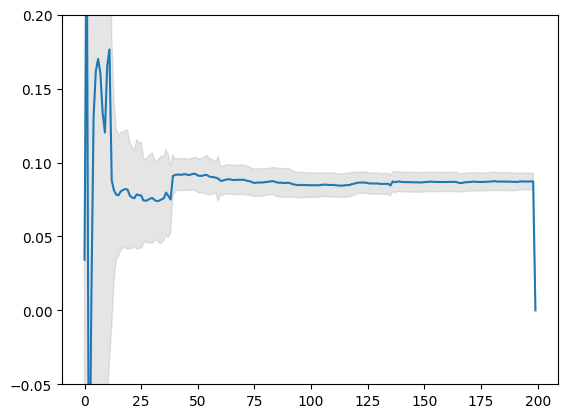

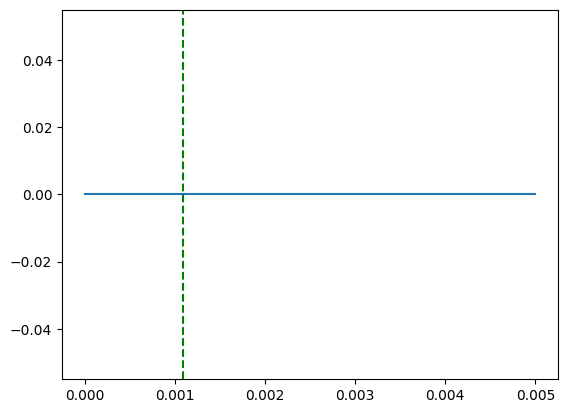

In [282]:
# import warnings
# warnings.filterwarnings('error', category = RuntimeWarning)
# warnings.filterwarnings('ignore', category = PendingDeprecationWarning)
# y_ns = y_ns[:,0]
n_mus = []
n_Ps = []
n_ws = []
num_particles = 50

# initialize x
mu_p_1 = np.matrix(np.zeros(3)).T
# mu_p_1[4:,0] = np.matrix([[mu_w1],[mu_w1]])
mu_p = [mu_p_1]*num_particles
P_p = [np.matrix(np.identity(3))*100]*num_particles
log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))

E_ns = np.zeros((num_particles, N+1)) # store exp likelihood of y

for n in range(N):
#     y_n = np.matrix(np.zeros(8)).T
#     y_n[:4]=np.matrix(y_ns[n]).T
    y_n = np.matrix(y_ns[n]).T
    m_n = np.matrix(m_ns_dt[n,:]).T
    s_n = np.matrix(s_ns[n,:,:])
    if n%5 == 0:
        resample = True
    else:
        resample = False
    
    log_weight_p, mu_p, P_p, E_ns = single_ite_particle_filtering_para1d(y_n, m_n, s_n, log_weight_p, mu_p, P_p, sigma_w, E_ns, n+1, resample = resample)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_ws.append(log_weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps) #* sigma_w**2
n_ws = np.array(n_ws)

average = np.zeros((N, 3))
std3 = np.zeros((N, 3))
avg_P = np.zeros((N, 3, 3))

for i in range(N-1):
    for d in range(3):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], np.exp(n_ws[i,:]))
        for j in range(3):
            avg_P[i,d,j] = np.dot(np.array(n_Ps[i,:,d,j].T), np.exp(n_ws[i,:]))+\
            np.dot((np.array(n_mus[i,:,d,:].T)[0]-average[i,d])*(np.array(n_mus[i,:,j,:].T)[0]-average[i,j]), np.exp(n_ws[i,:]))
            
        std3[i,d]=np.sqrt(avg_P[i,d,d])*3

# plot error region
dim = 2
plt.figure()
plt.fill_between(range(N),average[:,dim] - std3[:,dim], average[:,dim] + std3[:,dim],
                 color='gray', alpha=0.2)
plt.ylim([-0.05,0.2])
plt.plot(average[:,dim])

# plt.legend(['mu 1','mu 2'])
# plt.savefig('Langevin_nonzero_mus_fixjump.png')
print(average[-1,2])

betas = np.zeros(N)
alpha = alpha_w + N/2
xs = np.linspace(0.0,0.005,100)
fxs = 0
for p in range(num_particles):
    betas[p] = beta_w - sum(E_ns[p,:])
    x_beta = xs/betas[p]
    pdf = invgamma.pdf(x_beta, alpha)/betas[p]*np.exp(n_ws[-1,p])
    fxs += pdf
plt.figure()
plt.plot(xs, fxs)
plt.axvline(x = sigma_w**2, color = 'g', label = 'true sigma',linestyle='dashed',)

Text(0.5, 1.0, 'log of weight')

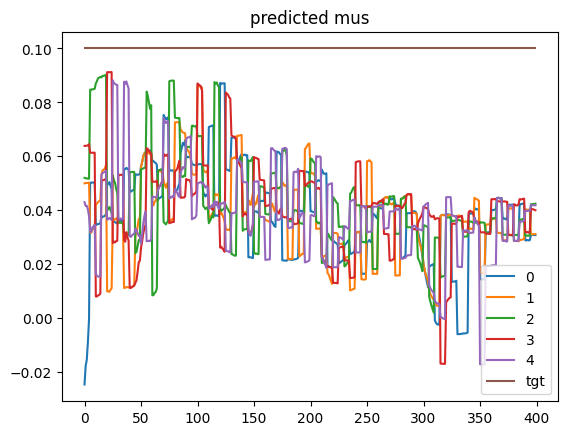

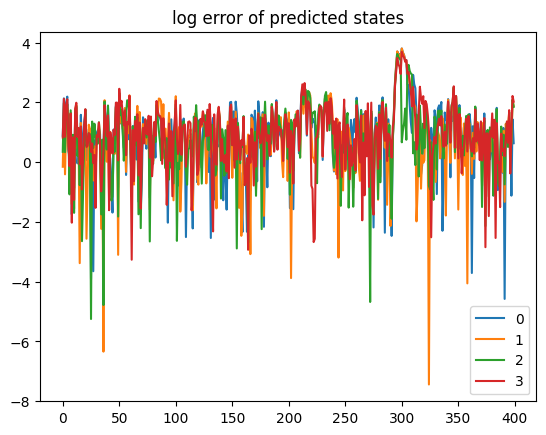

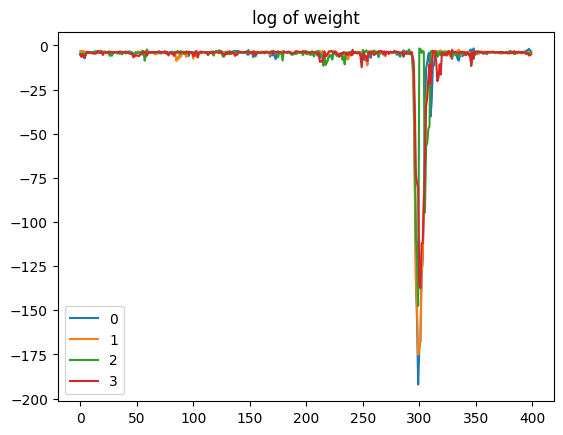

In [50]:
rootpath = r'C:\Users\95414\Desktop\CUED\phd\year1\code\levy_simu'
# plot for mus
labels = []
tgt = np.ones(N-100)*mu_w1
plt.figure()
for i in range(5):
    labels.append(str(i))
    plt.plot(n_mus[100:,i,4,:])

plt.plot(tgt)
labels.append('tgt')
# plt.ylim([-0.3,0.3])
plt.legend(labels)
plt.title('predicted mus')
# plt.savefig(f'{rootpath}\predictmu\mus.png')

# plot for xs
labels = []
plt.figure()
for i in range(4):
    labels.append(str(i))
    plt.plot(np.log(np.abs(y_ns[100:,0]-n_mus[100:,i,0,0])))
plt.title("log error of predicted states")
plt.plot()
plt.legend(labels)
# plt.savefig(f'{rootpath}\predictmu\states.png')

# plot for weights
plt.figure()
labels = []
for i in range(4):
    labels.append(str(i))
    plt.plot(n_ws[100:,i])
plt.legend(labels)
# plt.ylim([-10,0.0])
plt.title('log of weight')
# plt.savefig(f'{rootpath}\predictmu\weights.png')




IndexError: index 2 is out of bounds for axis 1 with size 2

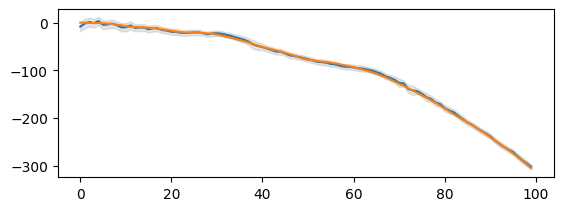

In [51]:
M = 100
plt.figure()
plt.subplot(2,1,1)
plt.fill_between(range(M), average[:M,2] - std3[:M,2], average[:M,2] + std3[:M,2],
                 color='gray', alpha=0.2)
plt.plot(average[:M,2])
plt.plot(x_ns[:M,2])
plt.plot(y_ns[:M,2])
plt.legend(['Tracking', 'True','Noisy'])
plt.subplot(2,1,2)
plt.fill_between(range(M), average[:M,0] - std3[:M,0], average[:M,0] + std3[:M,0],
                 color='gray', alpha=0.2)
plt.plot(average[:M,0])
plt.plot(x_ns[:M,0])
plt.plot(y_ns[:M,0])
plt.savefig('langevin_non_zero.png')
error = np.dot(average[:,0]-x_ns[:,0],average[:,0]-x_ns[:,0])/N
print(error)

In [ ]:
n_Ps.shape

(200, 10, 8, 8)